In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

## Dataset imports

### Asthma 1

In [2]:
from datetime import datetime

# Import asthma dataset
date_parser = lambda date : datetime.strptime(date, "%Y")
df = pd.read_csv(
    "Asthma Hospitalizations.csv",
    dtype={
        "Data":"float64"
    },
    parse_dates=["TimeFrame"],
    date_parser=date_parser
)
df["Year"] = df.TimeFrame.apply(lambda date: date.year)
print(df.dtypes)
df

Location              object
Age Group             object
TimeFrame     datetime64[ns]
DataFormat            object
Data                 float64
Fips                  object
Year                   int64
dtype: object


,Location,Age Group,TimeFrame,DataFormat,Data,Fips,Year
0,New York City,0 to 4 years,2000-01-01,Number,5727.0,3651000,2000
1,New York City,0 to 4 years,2001-01-01,Number,6024.0,3651000,2001
2,New York City,0 to 4 years,2003-01-01,Number,6591.0,3651000,2003
3,New York City,0 to 4 years,2004-01-01,Number,5823.0,3651000,2004
4,New York City,0 to 4 years,2005-01-01,Number,5027.0,3651000,2005
...,...,...,...,...,...,...,...
3258,South Beach - Tottenville,0 to 4 years,2005-01-01,Number,26.0,uhf504,2005
3259,South Beach - Tottenville,5 to 17 Years,2005-01-01,Number,22.0,uhf504,2005
3260,South Beach - Tottenville,0 to 4 years,2001-01-01,Number,29.0,uhf504,2001
3261,South Beach - Tottenville,0 to 4 years,2003-01-01,Number,36.0,uhf504,2003


In [3]:
# there is a problem with 0-4 years being in lower caps
df["Age Group"].unique()

array(['0 to 4 years', '5 to 17 Years', '0 to 17 Years'], dtype=object)

In [4]:
# we fix that
df["Age Group"] = df["Age Group"].str.replace("y","Y")

In [5]:
df

,Location,Age Group,TimeFrame,DataFormat,Data,Fips,Year
0,New York City,0 to 4 Years,2000-01-01,Number,5727.0,3651000,2000
1,New York City,0 to 4 Years,2001-01-01,Number,6024.0,3651000,2001
2,New York City,0 to 4 Years,2003-01-01,Number,6591.0,3651000,2003
3,New York City,0 to 4 Years,2004-01-01,Number,5823.0,3651000,2004
4,New York City,0 to 4 Years,2005-01-01,Number,5027.0,3651000,2005
...,...,...,...,...,...,...,...
3258,South Beach - Tottenville,0 to 4 Years,2005-01-01,Number,26.0,uhf504,2005
3259,South Beach - Tottenville,5 to 17 Years,2005-01-01,Number,22.0,uhf504,2005
3260,South Beach - Tottenville,0 to 4 Years,2001-01-01,Number,29.0,uhf504,2001
3261,South Beach - Tottenville,0 to 4 Years,2003-01-01,Number,36.0,uhf504,2003


In [6]:
# divide according to datatype and drop dataformat
df_num = df[df.DataFormat == "Number"]
df_rate = df[df.DataFormat == "Rate"]
df_num = df_num.rename(columns={"Data":"Numbers"})
df_num = df_num.drop(columns="DataFormat")
df_rate = df_rate.rename(columns={"Data":"Rate"})
df_rate = df_rate.drop(columns="DataFormat")

In [7]:
# df num has a age group that is just the sum of the other two
print(df_num["Age Group"].unique())
print(df_rate["Age Group"].unique())

['0 to 4 Years' '5 to 17 Years' '0 to 17 Years']
['0 to 4 Years' '5 to 17 Years']


In [8]:
# we see that 0-17 is just the sum of the other age groups
df_num[(df_num.Location == "New York City") & (df_num.TimeFrame== 2005)]

,Location,Age Group,TimeFrame,Numbers,Fips,Year


In [9]:
# we remove that
df_num = df_num[df_num["Age Group"] != "0 to 17 Years"]
df_num["Age Group"].unique()

array(['0 to 4 Years', '5 to 17 Years'], dtype=object)

In [10]:
# for some reason, there is a single datapoint less in rate than in numbers. We ignore this one datapoint
df_merged = pd.merge(df_num, df_rate, on = ["Location", "Age Group", "TimeFrame", "Fips", "Year"], how = "outer")
print(df_merged.shape)
df_merged[df_merged.Rate.isna()]

(1344, 7)


,Location,Age Group,TimeFrame,Numbers,Fips,Year,Rate
64,Bronx,0 to 4 Years,2006-01-01,1766.0,36005,2006,NaN


In [11]:
# merge datasets and rename
df_merged = pd.merge(df_num, df_rate, on = ["Location", "Age Group", "TimeFrame", "Fips", "Year"], how = "inner")
df_hosp = df_merged

In [12]:
# split timeframe into day month and year
df_hosp["Month"] = df_hosp.TimeFrame.apply(lambda date : date.month)
df_hosp["Day"] = df_hosp.TimeFrame.apply(lambda date : date.day)

# rename columns with spaces
df_hosp.rename(
    columns = {"Age Group" : "AgeGroup"}
)

,Location,AgeGroup,TimeFrame,Numbers,Fips,Year,Rate,Month,Day
0,New York City,0 to 4 Years,2000-01-01,5727.0,3651000,2000,106.2,1,1
1,New York City,0 to 4 Years,2001-01-01,6024.0,3651000,2001,112.5,1,1
2,New York City,0 to 4 Years,2003-01-01,6591.0,3651000,2003,124.1,1,1
3,New York City,0 to 4 Years,2004-01-01,5823.0,3651000,2004,109.5,1,1
4,New York City,0 to 4 Years,2005-01-01,5027.0,3651000,2005,95.1,1,1
...,...,...,...,...,...,...,...,...,...
1338,South Beach - Tottenville,0 to 4 Years,2005-01-01,26.0,uhf504,2005,24.3,1,1
1339,South Beach - Tottenville,5 to 17 Years,2005-01-01,22.0,uhf504,2005,6.7,1,1
1340,South Beach - Tottenville,0 to 4 Years,2001-01-01,29.0,uhf504,2001,25.7,1,1
1341,South Beach - Tottenville,0 to 4 Years,2003-01-01,36.0,uhf504,2003,32.7,1,1


### Air quality

In [13]:
# import air quality dataset
date_parser = lambda x: datetime.strptime(x, '%m/%d/%Y') # specify the date
df_air = pd.read_csv(
    "Air_Quality.csv",
    dtype={
        "Unique ID":"int64",
        "Indicator ID":"int64",
        "Geo Join ID":"int64",
        "Data Value":"float64",
    },
    parse_dates=["Start_Date"],
    date_parser=date_parser
)
df_air = df_air.drop(columns=["Message"])
print(df_air.dtypes)

Unique ID                  int64
Indicator ID               int64
Name                      object
Measure                   object
Measure Info              object
Geo Type Name             object
Geo Join ID                int64
Geo Place Name            object
Time Period               object
Start_Date        datetime64[ns]
Data Value               float64
dtype: object


In [14]:
# split date into day, month and year
df_air["Year"] = df_air.Start_Date.apply(lambda date: date.year)
df_air["Month"] = df_air.Start_Date.apply(lambda date: date.month)
df_air["Day"] = df_air.Start_Date.apply(lambda date: date.day)

# rename columns with spaces
df_air = df_air.rename(
    columns = {
        "Unique ID" : "UniqueID",
        "Indicator ID" : "IndicatorID",
        "Measure Info" : "MeasureInfo",
        "Geo Type Name" : "GeoTypeName",
        "Geo Join ID" : "GeoJoinID",
        "Geo Place Name" : "GeoPlaceName",
        "Time Period" : "TimePeriod",
        "Start_Date" : "StartDate",
        "Data Value" : "Value",
    }
)

df_air

,UniqueID,IndicatorID,Name,Measure,MeasureInfo,GeoTypeName,GeoJoinID,GeoPlaceName,TimePeriod,StartDate,Value,Year,Month,Day
0,130355,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,101,Kingsbridge - Riverdale,2005-2007,2005-01-01,117.70,2005,1,1
1,130356,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,102,Northeast Bronx,2005-2007,2005-01-01,77.30,2005,1,1
2,130357,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,103,Fordham - Bronx Pk,2005-2007,2005-01-01,67.30,2005,1,1
3,130358,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,104,Pelham - Throgs Neck,2005-2007,2005-01-01,73.60,2005,1,1
4,130359,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,105,Crotona -Tremont,2005-2007,2005-01-01,65.80,2005,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16117,671118,386,Ozone (O3),Mean,ppb,CD,306,Park Slope and Carroll Gardens (CD6),Summer 2020,2020-06-01,28.70,2020,6,1
16118,671119,386,Ozone (O3),Mean,ppb,CD,305,East New York and Starrett City (CD5),Summer 2020,2020-06-01,29.56,2020,6,1
16119,671120,386,Ozone (O3),Mean,ppb,CD,304,Bushwick (CD4),Summer 2020,2020-06-01,29.65,2020,6,1
16120,671121,386,Ozone (O3),Mean,ppb,CD,303,Bedford Stuyvesant (CD3),Summer 2020,2020-06-01,29.28,2020,6,1


### Asthma 2

In [15]:
# handmade column names to get around multi-indexing
cols = ["Location"]
for year in range(2005, 2017):
    for cat in ("0-4y","5-17y","0-17y"):
        col = f"{year}_{cat}"
        cols.append(col)
print(cols)

['Location', '2005_0-4y', '2005_5-17y', '2005_0-17y', '2006_0-4y', '2006_5-17y', '2006_0-17y', '2007_0-4y', '2007_5-17y', '2007_0-17y', '2008_0-4y', '2008_5-17y', '2008_0-17y', '2009_0-4y', '2009_5-17y', '2009_0-17y', '2010_0-4y', '2010_5-17y', '2010_0-17y', '2011_0-4y', '2011_5-17y', '2011_0-17y', '2012_0-4y', '2012_5-17y', '2012_0-17y', '2013_0-4y', '2013_5-17y', '2013_0-17y', '2014_0-4y', '2014_5-17y', '2014_0-17y', '2015_0-4y', '2015_5-17y', '2015_0-17y', '2016_0-4y', '2016_5-17y', '2016_0-17y']


In [16]:
# import dataset
dtypes = {col:("str" if i==0 else "int") for i,col in enumerate(cols)}
df_hosp2 = pd.read_csv("Asthma_total_data2.csv", sep=";", names=cols).iloc[2:,:]
df_hosp2 = df_hosp2.astype(dtypes)
df_hosp2.head()

,Location,2005_0-4y,2005_5-17y,2005_0-17y,2006_0-4y,2006_5-17y,2006_0-17y,2007_0-4y,2007_5-17y,2007_0-17y,...,2013_0-17y,2014_0-4y,2014_5-17y,2014_0-17y,2015_0-4y,2015_5-17y,2015_0-17y,2016_0-4y,2016_5-17y,2016_0-17y
0.0,New York City,5027,4656,9683,5164,4525,9689,4665,4194,8859,...,7738,3922,4106,8028,3514,3547,7061,3380,3373,6753
1.0,Bronx,1791,1594,3385,1766,1542,3308,1691,1476,3167,...,3166,1569,1691,3260,1407,1489,2896,1317,1340,2657
2.0,Brooklyn,1481,1414,2895,158,1424,3004,1309,1200,2509,...,2233,1147,1155,2302,1023,994,2017,977,990,1967
3.0,Manhattan,597,698,1295,654,605,1259,526,598,1124,...,901,460,482,942,400,421,821,416,440,856
4.0,Queens,1026,831,1857,1048,823,1871,1033,814,1847,...,1239,654,663,1317,602,540,1142,559,506,1650


In [17]:
# use regex to get the UHF code from location
def get_uhf_hosp2(location):
    re_s = re.search("\(.*?\)", location)
    if re_s: return location[re_s.span()[0]+1:-1]
    else: return 0

In [18]:
# melt dataset such that each row is a sample (like the other datasets)

df_hosp2_melted = df_hosp2.melt(id_vars="Location", value_vars=list(df_hosp2.columns[1:]), var_name="Year and age", value_name="n")
df_hosp2_melted["Year"] = df_hosp2_melted["Year and age"].str[0:4].astype("int")
df_hosp2_melted["AgeGroup"] = df_hosp2_melted["Year and age"].str[5:].astype("str")
df_hosp2_melted["Uhf"] = df_hosp2_melted.Location.apply(get_uhf_hosp2)
df_hosp2_melted["Uhf"] = df_hosp2_melted["Uhf"].astype("int")
print(df_hosp2_melted.dtypes)

df_hosp2_melted

Location        object
Year and age    object
n                int64
Year             int64
AgeGroup        object
Uhf              int64
dtype: object


,Location,Year and age,n,Year,AgeGroup,Uhf
0,New York City,2005_0-4y,5027,2005,0-4y,0
1,Bronx,2005_0-4y,1791,2005,0-4y,0
2,Brooklyn,2005_0-4y,1481,2005,0-4y,0
3,Manhattan,2005_0-4y,597,2005,0-4y,0
4,Queens,2005_0-4y,1026,2005,0-4y,0
...,...,...,...,...,...,...
1723,Upper West Side(304),2016_0-17y,43,2016,0-17y,304
1724,Washington Heights - Inwood(301),2016_0-17y,210,2016,0-17y,301
1725,West Queens(402),2016_0-17y,199,2016,0-17y,402
1726,Williamsburg - Bushwick(211),2016_0-17y,240,2016,0-17y,211


## Misc plots and maps

In [19]:
# there seems to be more data with the per 100.000 adults metric
print(df_air[df_air.MeasureInfo == "ppb"].shape)
print(df_air[df_air.MeasureInfo != "ppb"].shape)

(7896, 14)
(8226, 14)


<AxesSubplot:xlabel='Month'>

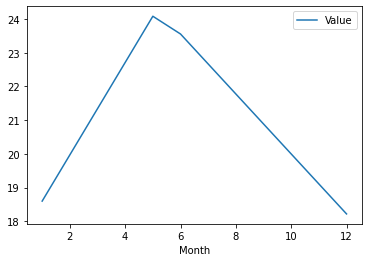

In [20]:
# check the monnthly change
df_air[df_air.MeasureInfo == "ppb"][["Value","Month"]].groupby("Month").mean().plot()

In [21]:
df_air[df_air.MeasureInfo == "ppb"].Month.unique() # only 4 datapoints so not so representative but it still changes a lot

array([12,  6,  1,  5])

<AxesSubplot:xlabel='Year'>

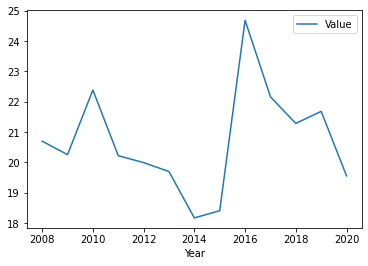

In [22]:
df_air[df_air.MeasureInfo == "ppb"][["Value","Year"]].groupby("Year").mean().plot()

In [23]:
df_rate

,Location,Age Group,TimeFrame,Rate,Fips,Year
40,New York City,0 to 4 Years,2016-01-01,61.1,3651000,2016
41,New York City,5 to 17 Years,2016-01-01,27.2,3651000,2016
42,New York City,0 to 4 Years,2015-01-01,62.6,3651000,2015
43,New York City,5 to 17 Years,2015-01-01,28.9,3651000,2015
44,New York City,5 to 17 Years,2014-01-01,33.5,3651000,2014
...,...,...,...,...,...,...
3218,South Beach - Tottenville,0 to 4 Years,2014-01-01,21.0,uhf504,2014
3219,South Beach - Tottenville,0 to 4 Years,2016-01-01,23.4,uhf504,2016
3220,South Beach - Tottenville,5 to 17 Years,2016-01-01,3.9,uhf504,2016
3223,South Beach - Tottenville,0 to 4 Years,2015-01-01,10.6,uhf504,2015


<AxesSubplot:xlabel='StartDate', ylabel='Value'>

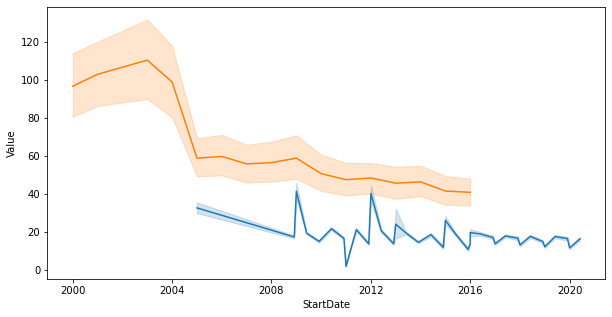

In [24]:
# compare asthma rate and polution values. Very simplified. A shame that we don't have data from before 2004. It looks quite interesting
plt.figure(figsize=(10,5))
sns.lineplot(data = df_air[["StartDate", "Value"]], x = "StartDate", y = "Value")
sns.lineplot(data = df_hosp[["TimeFrame","Rate"]], x = "TimeFrame", y = "Rate")

In [25]:
#Import Libraries for map plotting
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
from folium.features import GeoJsonTooltip

#Read the geoJSON file using geopandas
geojson = gpd.read_file("georef-united-states-of-america-county.geojson")
#geojson = geojson[['coty_code','geometry']] #only select 'coty_code' (country fips) and 'geometry' columns

In [26]:
# The datasets use UHF42 shapefiles. We import those

uhf42shapes = gpd.read_file(
    "UHF_42_DOHMH_2009/UHF_42_DOHMH_2009.shp",
    dtypes = {"UHFCODE":"int"}
)
uhf42shapes["UHFCODE"] = uhf42shapes.UHFCODE.astype("int")
uhf42shapes.head()

,OBJECTID,UHFCODE,SHAPE_Leng,SHAPE_Area,UHF_NEIGH,BOROUGH,geometry
0,1,0,207587.595627,2.764099e+08,None,N/A,"MULTIPOLYGON (((1052698.331 161778.389, 105230..."
1,2,101,57699.154353,1.332914e+08,Kingsbridge - Riverdale,Bronx,"POLYGON ((1017992.893 269222.964, 1017812.000 ..."
2,3,102,88219.319109,1.813708e+08,Northeast Bronx,Bronx,"POLYGON ((1025012.990 270794.260, 1025061.481 ..."
3,4,103,59711.871991,1.407724e+08,Fordham - Bronx Park,Bronx,"POLYGON ((1023994.480 261065.967, 1023885.806 ..."
4,5,104,250903.372273,3.865737e+08,Pelham - Throgs Neck,Bronx,"MULTIPOLYGON (((1017075.039 237316.182, 101707..."


In [27]:
# check if it matches the dataset
for id in df_air[df_air.GeoTypeName == "UHF42"].GeoJoinID:
    if not id in list(uhf42shapes.UHFCODE): print(id) # print UHF42 ID if not a shapefile is not present

In [28]:
# they are all here. We remove unecesary columns
geojson_ny = uhf42shapes[["UHFCODE", "geometry"]]

# merge shapefiles into df air. not used but might be useful
df_air_geo = df_air.merge(geojson_ny, left_on = "GeoJoinID", right_on = "UHFCODE", how = "left")

In [29]:
# get the mean polution per neighbourhood
df_air_choro = df_air[df_air.MeasureInfo == "ppb"][["Value","GeoJoinID"]].groupby("GeoJoinID", as_index=0).mean()
df_air_choro

,GeoJoinID,Value
0,1,19.680399
1,2,19.950179
2,3,23.686786
3,4,19.425714
4,5,16.144643
...,...,...
67,309310,23.672321
68,404406,18.727143
69,501502,17.494821
70,503504,15.574464


In [30]:
import folium
from folium import plugins
from folium.plugins import HeatMap

lat, lon = 40.682030, -74.046082
map_ny = folium.Map([lat, lon], zoom_start=11, tiles = "cartodbpositron")
map_ny.choropleth(
    geo_data=geojson_ny,
    name='Choropleth',
    data=df_air_choro,
    columns=['GeoJoinID','Value'],
    key_on="properties.UHFCODE",
    fill_color='YlGnBu',
    fill_opacity=1,
    line_opacity=0.2,
    legend_name='Mean air polution value in ppb',
    smooth_factor=0
)
map_ny

/Users/lluiscolomercoll/opt/anaconda3/lib/python3.8/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [31]:
df_hosp

,Location,Age Group,TimeFrame,Numbers,Fips,Year,Rate,Month,Day
0,New York City,0 to 4 Years,2000-01-01,5727.0,3651000,2000,106.2,1,1
1,New York City,0 to 4 Years,2001-01-01,6024.0,3651000,2001,112.5,1,1
2,New York City,0 to 4 Years,2003-01-01,6591.0,3651000,2003,124.1,1,1
3,New York City,0 to 4 Years,2004-01-01,5823.0,3651000,2004,109.5,1,1
4,New York City,0 to 4 Years,2005-01-01,5027.0,3651000,2005,95.1,1,1
...,...,...,...,...,...,...,...,...,...
1338,South Beach - Tottenville,0 to 4 Years,2005-01-01,26.0,uhf504,2005,24.3,1,1
1339,South Beach - Tottenville,5 to 17 Years,2005-01-01,22.0,uhf504,2005,6.7,1,1
1340,South Beach - Tottenville,0 to 4 Years,2001-01-01,29.0,uhf504,2001,25.7,1,1
1341,South Beach - Tottenville,0 to 4 Years,2003-01-01,36.0,uhf504,2003,32.7,1,1


In [32]:
def remove_paranthesis(s):
    if re.search("\(.*?\)",s):
        i1, i2 = re.search("\(.*?\)",s).span()
        return s[:i1]
    return s

In [33]:
air_names = {remove_paranthesis(name) for name in df_air.GeoPlaceName.unique()}

In [34]:
hosp_names = {remove_paranthesis(name) for name in df_hosp.Location.unique()}

In [35]:
air_names.symmetric_difference(hosp_names)
hosp_names.difference(air_names)

{'Crotona - Tremont',
 'Downtown  - Heights - Slope',
 'Fordham - Bronx Park',
 'Gramercy Park -  Murray Hill',
 'Greenwich Village - Soho',
 'Port  Richmond',
 'Rockaway',
 'Washington Heights - Inwood'}

In [36]:
df_plots = df_air[["Value", "Year", "GeoPlaceName"]].merge(df_hosp[["Rate", "Year", "Location"]], left_on = ["GeoPlaceName","Year"], right_on = ["Location","Year"], how="left")

In [37]:
df_plots = df_plots.dropna()
df_plots = df_plots.drop(columns=("GeoPlaceName"))

In [38]:
df_plots

,Value,Year,Rate,Location
0,117.7,2005,56.4,Kingsbridge - Riverdale
1,117.7,2005,18.9,Kingsbridge - Riverdale
2,77.3,2005,110.4,Northeast Bronx
3,77.3,2005,42.7,Northeast Bronx
5,73.6,2005,139.0,Pelham - Throgs Neck
...,...,...,...,...
20531,7.7,2015,5.4,Willowbrook
20532,7.7,2015,10.6,South Beach - Tottenville
20533,7.7,2015,8.7,South Beach - Tottenville
20534,4.8,2015,62.6,New York City


In [39]:
cities20 = df_plots.groupby("Location", as_index=0).count().sort_values("Year", ascending=False).Location[:5]
idx = cities20.index
cities20

20    Long Island City - Astoria
12                 East New York
25          Pelham - Throgs Neck
24               Northeast Bronx
29              Southeast Queens
Name: Location, dtype: object

In [40]:
d = df_plots.groupby(["Location", "Year"], as_index=0).mean()

In [41]:
d

,Location,Year,Value,Rate
0,Bayside - Little Neck,2005,15.626667,18.30
1,Bayside - Little Neck,2008,14.192000,34.35
2,Bayside - Little Neck,2009,13.997222,29.25
3,Bayside - Little Neck,2010,16.413750,17.55
4,Bayside - Little Neck,2011,11.941000,11.70
...,...,...,...,...
395,Willowbrook,2012,17.382548,17.95
396,Willowbrook,2013,10.122727,13.10
397,Willowbrook,2014,13.020000,14.75
398,Willowbrook,2015,13.074348,15.45


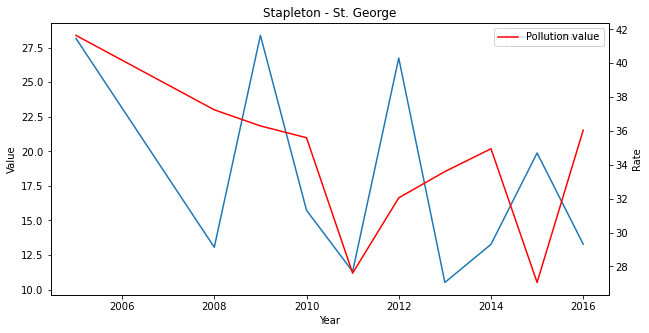

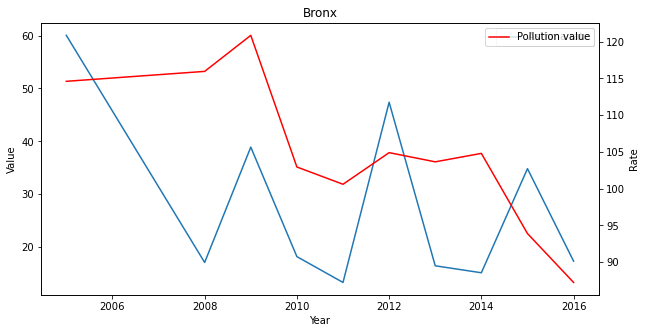

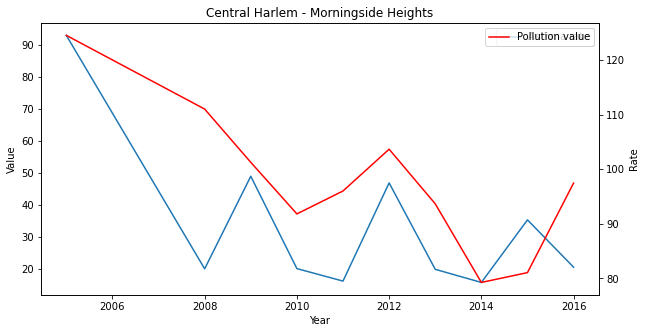

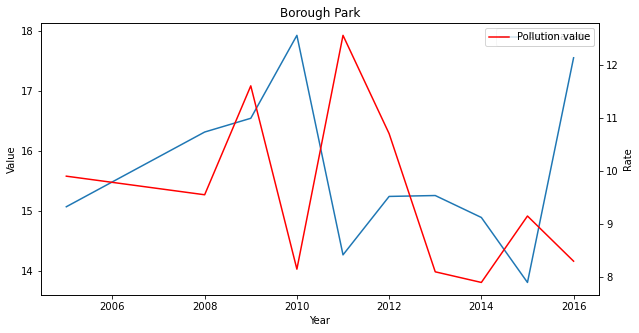

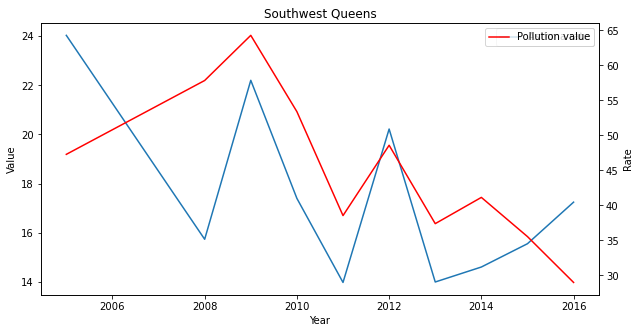

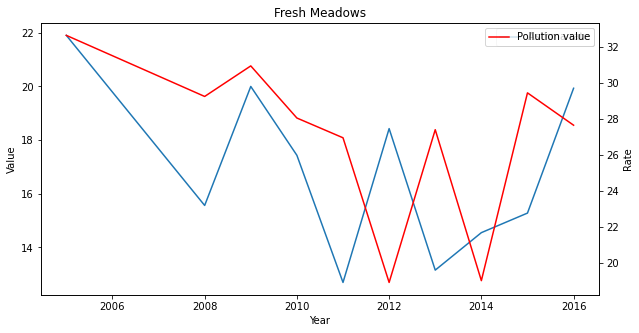

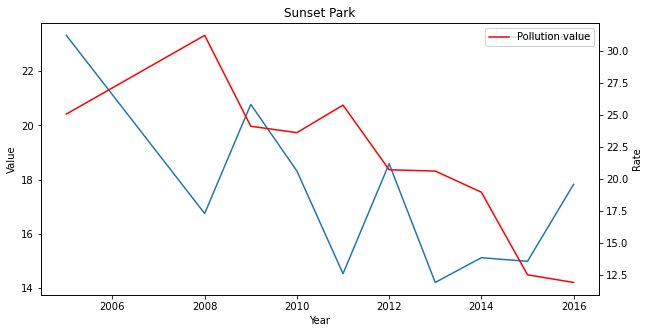

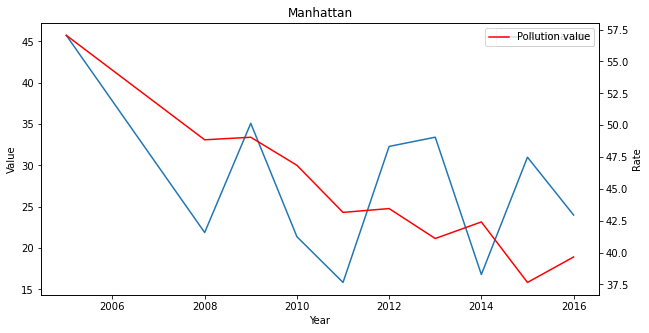

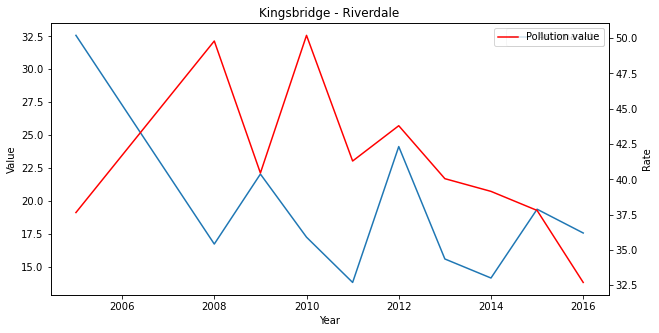

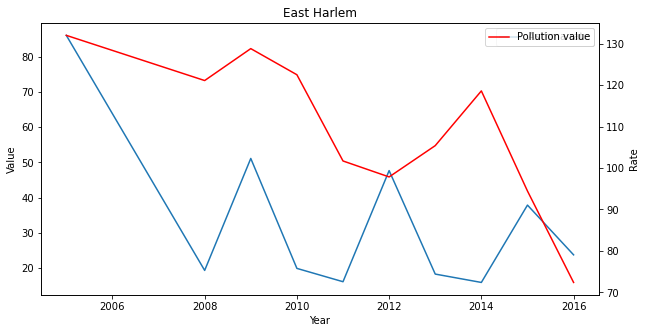

In [42]:
rand_cities = [d.Location[np.random.randint(400)] for _ in range(10)]
for city in rand_cities:
    plt.figure(figsize = (10,5))
    sns.lineplot(data = d[d.Location == city], x = "Year", y = "Value",label='Asthma rate').set_title(city)
    plt.twinx()
    sns.lineplot(data = d[d.Location == city], x = "Year", y = "Rate",label='Pollution value', color = "r")
    plt.legend()

<AxesSubplot:xlabel='Rate', ylabel='Value'>

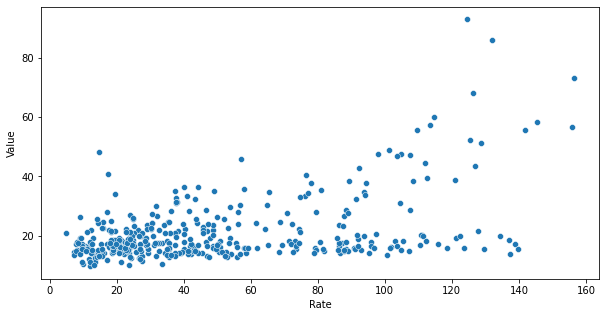

In [43]:
plt.figure(figsize = (10,5))
sns.scatterplot(x = d["Rate"], y= d["Value"])

In [44]:
d[["Value", "Rate"]].corr()

,Value,Rate
Value,1.000000,0.480521
Rate,0.480521,1.000000


In [45]:
df_hosp2_melted

,Location,Year and age,n,Year,AgeGroup,Uhf
0,New York City,2005_0-4y,5027,2005,0-4y,0
1,Bronx,2005_0-4y,1791,2005,0-4y,0
2,Brooklyn,2005_0-4y,1481,2005,0-4y,0
3,Manhattan,2005_0-4y,597,2005,0-4y,0
4,Queens,2005_0-4y,1026,2005,0-4y,0
...,...,...,...,...,...,...
1723,Upper West Side(304),2016_0-17y,43,2016,0-17y,304
1724,Washington Heights - Inwood(301),2016_0-17y,210,2016,0-17y,301
1725,West Queens(402),2016_0-17y,199,2016,0-17y,402
1726,Williamsburg - Bushwick(211),2016_0-17y,240,2016,0-17y,211


In [46]:
df_hosp2_melted_mean = df_hosp2_melted[["Uhf","n"]].groupby("Uhf", as_index=0).mean()
df_hosp2_melted = df_hosp2_melted[df_hosp2_melted.Uhf != 0]
df_hosp2_melted_mean.head()

,Uhf,n
0,0,1837.754630
1,101,42.444444
2,102,197.277778
3,103,390.277778
4,104,352.111111


In [47]:
import folium
from folium import plugins
from folium.plugins import HeatMap

lat, lon = 40.682030, -74.046082
map_ny = folium.Map([lat, lon], zoom_start=11, tiles = "cartodbpositron")
map_ny.choropleth(
    geo_data=geojson_ny,
    name='Choropleth',
    data=df_hosp2_melted_mean,
    columns=['Uhf','n'],
    key_on="properties.UHFCODE",
    fill_color='YlGnBu',
    fill_opacity=1,
    line_opacity=0.2,
    legend_name='n',
    smooth_factor=0
)
map_ny

/Users/lluiscolomercoll/opt/anaconda3/lib/python3.8/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


## Timeseries choropleth of polution and asthma

In [48]:
df_hosp2_melted.head()

,Location,Year and age,n,Year,AgeGroup,Uhf
6,Bayside - Little Neck(404),2005_0-4y,10,2005,0-4y,404
7,Bedford Stuyvesant - Crown Heights(203),2005_0-4y,379,2005,0-4y,203
8,Bensonhurst - Bay Ridge(209),2005_0-4y,20,2005,0-4y,209
9,Borough Park(206),2005_0-4y,42,2005,0-4y,206
10,Canarsie - Flatlands(208),2005_0-4y,106,2005,0-4y,208


In [49]:
df_air.head()

,UniqueID,IndicatorID,Name,Measure,MeasureInfo,GeoTypeName,GeoJoinID,GeoPlaceName,TimePeriod,StartDate,Value,Year,Month,Day
0,130355,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,101,Kingsbridge - Riverdale,2005-2007,2005-01-01,117.7,2005,1,1
1,130356,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,102,Northeast Bronx,2005-2007,2005-01-01,77.3,2005,1,1
2,130357,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,103,Fordham - Bronx Pk,2005-2007,2005-01-01,67.3,2005,1,1
3,130358,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,104,Pelham - Throgs Neck,2005-2007,2005-01-01,73.6,2005,1,1
4,130359,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,105,Crotona -Tremont,2005-2007,2005-01-01,65.8,2005,1,1


In [50]:
df_air.Name.unique()

array(['PM2.5-Attributable Deaths',
       'Boiler Emissions- Total SO2 Emissions',
       'Boiler Emissions- Total PM2.5 Emissions',
       'Boiler Emissions- Total NOx Emissions',
       'Air Toxics Concentrations- Average Benzene Concentrations',
       'Air Toxics Concentrations- Average Formaldehyde Concentrations',
       'PM2.5-Attributable Asthma Emergency Department Visits',
       'PM2.5-Attributable Respiratory Hospitalizations (Adults 20 Yrs and Older)',
       'PM2.5-Attributable Cardiovascular Hospitalizations (Adults 40 Yrs and Older)',
       'O3-Attributable Cardiac and Respiratory Deaths',
       'O3-Attributable Asthma Emergency Department Visits',
       'O3-Attributable Asthma Hospitalizations',
       'Traffic Density- Annual Vehicle Miles Traveled',
       'Traffic Density- Annual Vehicle Miles Traveled for Cars',
       'Traffic Density- Annual Vehicle Miles Traveled for Trucks',
       'Sulfur Dioxide (SO2)', 'Nitrogen Dioxide (NO2)',
       'Fine Particulate M

In [51]:
from folium.plugins import TimeSliderChoropleth

In [52]:
# create dataset consisting of the inner join of df_air and df_hosp2_melted, merged on UHF and YEAR
gb_hosp = df_hosp2_melted[df_hosp2_melted.AgeGroup == "0-17y"].groupby(["Uhf", "Year"], as_index=False).mean() # get hospitalization data grouped by year and neighbourhood
gb_air = df_air[df_air.Name == "Fine Particulate Matter (PM2.5)"][["Year","Value","GeoJoinID"]].groupby(["GeoJoinID", "Year"], as_index=False).mean()

In [53]:
df_hosp.Year.unique()

array([2000, 2001, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016])

In [54]:
df_air.Year.unique()

array([2005, 2013, 2009, 2008, 2010, 2011, 2012, 2015, 2014, 2016, 2017,
       2018, 2019, 2020])

In [55]:
gb_chorotime = gb_hosp.merge(gb_air, left_on=["Year","Uhf"], right_on=["Year", "GeoJoinID"], how = "inner")

In [56]:
# rename, change dtypes and remove duplicate columns
gb_chorotime = gb_chorotime.rename(
    columns={
        "n" : "Hosp_value",
        "Value" : "Air_value",
    }
)

gb_chorotime = gb_chorotime.astype({"Year":"int", "Uhf":"int"})

gb_chorotime = gb_chorotime.drop(columns="GeoJoinID")

gb_chorotime["Hosp_value"] = gb_chorotime.Hosp_value / max(gb_chorotime.Hosp_value) # map to values between 0 and 1
gb_chorotime["Air_value"] = gb_chorotime.Air_value / max(gb_chorotime.Air_value) # --//--
gb_chorotime

,Uhf,Year,Hosp_value,Air_value
0,101,2008,0.102453,0.864973
1,101,2009,0.088023,0.730143
2,101,2010,0.106782,0.819694
3,101,2011,0.093795,0.698063
4,101,2012,0.096681,0.696265
...,...,...,...,...
373,504,2012,0.054834,0.586287
374,504,2013,0.056277,0.623186
375,504,2014,0.057720,0.505583
376,504,2015,0.054834,0.476453


In [57]:
# create colormap for plotting polution
import branca.colormap as cm
colormap = cm.LinearColormap(vmin=0, vmax=1, colors=["lightgreen", "black"])
print(colormap(0.2))
colormap

#73bf73ff


In [58]:
# creating the style dict for the choropleth.
# it consists of a dict of dicts of dicts.
# styledict = {
#     shapefile_index : {
#         date_in_unix_time : {color:, opacity:},
#         date_in_unix_time : {color:, opacity:},
#         date_in_unix_time : {color:, opacity:}
#     }
#     shapefile_index : {
#         date_in_unix_time : {color:, opacity:},
#         date_in_unix_time : {color:, opacity:},
#         date_in_unix_time : {color:, opacity:}
#     }
# }

uhf_to_idx = {row.UHFCODE:str(idx) for idx, row in geojson_ny.iterrows()} # map uhf to index in geojson

style_dict = {}
for idx, uhf, year, hosp_value, air_value in gb_chorotime.itertuples():    
    year_epoch = str(datetime(year, 1, 1).timestamp()) # convert year to ms after epoch

    if uhf_to_idx[uhf] in style_dict: style_dict[uhf_to_idx[uhf]][year_epoch] = {"color":colormap(air_value), "opacity":hosp_value}
    else: style_dict[uhf_to_idx[uhf]] = {year_epoch: {"color":colormap(air_value),"opacity":hosp_value}}

In [59]:
uhf42shapes_converted = uhf42shapes.to_crs(epsg=4326) # convert to format compatible with timeslider choropleth

In [60]:
# plot

lat, lon = 40.682030, -74.046082
map_ny = folium.Map([lat, lon], zoom_start=11, tiles = "cartodbpositron")

# folium.Choropleth(
#     geo_data=geojson_ny,
#     name='Choropleth',
#     data=df_hosp2_melted_mean,
#     columns=['Uhf','n'],
#     key_on="properties.UHFCODE",
#     fill_color='YlGnBu',
#     fill_opacity=0.5,
#     line_opacity=0.2,
#     legend_name='n',
#     smooth_factor=0
# ).add_to(map_ny)

TimeSliderChoropleth(
    #geojson_ny.to_json(),
    uhf42shapes_converted.to_json(),
    style_dict
).add_to(map_ny)

map_ny

In [61]:
gb_chorotime

,Uhf,Year,Hosp_value,Air_value
0,101,2008,0.102453,0.864973
1,101,2009,0.088023,0.730143
2,101,2010,0.106782,0.819694
3,101,2011,0.093795,0.698063
4,101,2012,0.096681,0.696265
...,...,...,...,...
373,504,2012,0.054834,0.586287
374,504,2013,0.056277,0.623186
375,504,2014,0.057720,0.505583
376,504,2015,0.054834,0.476453


In [62]:
def plot_pollution_per_district(UHF):
    plt.plot(gb_chorotime[gb_chorotime.Uhf==UHF].Year,
         gb_chorotime[gb_chorotime.Uhf==UHF].Hosp_value,label='Astha hosp')
    plt.plot(gb_chorotime[gb_chorotime.Uhf==UHF].Year,
         gb_chorotime[gb_chorotime.Uhf==UHF].Air_value,label='Air pollution')
    plt.title('district '+str(UHF));plt.legend();plt.show()

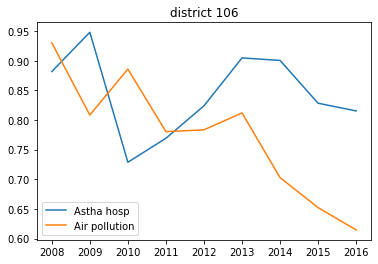

In [63]:
plot_pollution_per_district(106)

Let's study this particular case:

In [64]:
df_air[df_air.GeoJoinID==106]

,UniqueID,IndicatorID,Name,Measure,MeasureInfo,GeoTypeName,GeoJoinID,GeoPlaceName,TimePeriod,StartDate,Value,Year,Month,Day
5,130360,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,106,High Bridge - Morrisania,2005-2007,2005-01-01,84.80,2005,1,1
47,130402,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,106,High Bridge - Morrisania,2013,2013-01-01,19.70,2013,1,1
95,130450,641,Boiler Emissions- Total PM2.5 Emissions,Number per km2,number,UHF42,106,High Bridge - Morrisania,2013,2013-01-01,2.40,2013,1,1
143,130498,642,Boiler Emissions- Total NOx Emissions,Number per km2,number,UHF42,106,High Bridge - Morrisania,2013,2013-01-01,78.00,2013,1,1
191,130690,646,Air Toxics Concentrations- Average Benzene Con...,Annual Average Concentration,µg/m3,UHF42,106,High Bridge - Morrisania,2005,2005-01-01,3.00,2005,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15817,669821,365,Fine Particulate Matter (PM2.5),Mean,mcg per cubic meter,UHF42,106,High Bridge - Morrisania,Summer 2020,2020-06-01,7.24,2020,6,1
15818,669822,365,Fine Particulate Matter (PM2.5),Mean,mcg per cubic meter,UHF42,106,High Bridge - Morrisania,Winter 2019-20,2019-12-01,7.11,2019,12,1
15819,669823,365,Fine Particulate Matter (PM2.5),Mean,mcg per cubic meter,UHF42,106,High Bridge - Morrisania,Annual Average 2020,2020-01-01,6.12,2020,1,1
16000,670897,386,Ozone (O3),Mean,ppb,CD,106,Stuyvesant Town and Turtle Bay (CD6),Summer 2020,2020-06-01,28.13,2020,6,1


In [65]:
np.unique(df_air[df_air.GeoJoinID==106].Name)

array(['Air Toxics Concentrations- Average Benzene Concentrations',
       'Air Toxics Concentrations- Average Formaldehyde Concentrations',
       'Boiler Emissions- Total NOx Emissions',
       'Boiler Emissions- Total PM2.5 Emissions',
       'Boiler Emissions- Total SO2 Emissions',
       'Fine Particulate Matter (PM2.5)', 'Nitrogen Dioxide (NO2)',
       'O3-Attributable Asthma Emergency Department Visits',
       'O3-Attributable Asthma Hospitalizations',
       'O3-Attributable Cardiac and Respiratory Deaths', 'Ozone (O3)',
       'PM2.5-Attributable Asthma Emergency Department Visits',
       'PM2.5-Attributable Cardiovascular Hospitalizations (Adults 40 Yrs and Older)',
       'PM2.5-Attributable Deaths',
       'PM2.5-Attributable Respiratory Hospitalizations (Adults 20 Yrs and Older)',
       'Sulfur Dioxide (SO2)',
       'Traffic Density- Annual Vehicle Miles Traveled',
       'Traffic Density- Annual Vehicle Miles Traveled for Cars',
       'Traffic Density- Annual Vehicl

In [66]:
district_106=df_air[df_air.GeoJoinID==106]
district_106=district_106.reset_index()

In [67]:
district_106[district_106.Name=='Air Toxics Concentrations- Average Benzene Concentrations']

,index,UniqueID,IndicatorID,Name,Measure,MeasureInfo,GeoTypeName,GeoJoinID,GeoPlaceName,TimePeriod,StartDate,Value,Year,Month,Day
4,191,130690,646,Air Toxics Concentrations- Average Benzene Con...,Annual Average Concentration,µg/m3,UHF42,106,High Bridge - Morrisania,2005,2005-01-01,3.000000,2005,1,1
131,8487,227573,646,Air Toxics Concentrations- Average Benzene Con...,Annual Average Concentration,µg/m3,CD,106,Stuyvesant Town and Turtle Bay (CD6),2011,2011-01-01,2.467445,2011,1,1
132,8551,315595,646,Air Toxics Concentrations- Average Benzene Con...,Annual Average Concentration,µg/m3,UHF42,106,High Bridge - Morrisania,2011,2011-01-01,1.600000,2011,1,1


### Simple machine learning model to predict number of Asthma Hosp

In [103]:
var=['Sulfur Dioxide (SO2)','Ozone (O3)','Nitrogen Dioxide (NO2)','Fine Particulate Matter (PM2.5)']
age_groups=['0-4y','5-17y']
districts=np.unique(df_hosp2_melted.Uhf)

machine_df=[]
for district_num in districts:
    district_data=df_air[df_air.GeoJoinID==district_num]
    district_data=district_data[district_data.GeoTypeName=='UHF42']
    district_data=district_data.reset_index()
    asthma_data=df_hosp2_melted[df_hosp2_melted.Uhf==district_num]
    
    for year in range(2009,2017):
        for age_group in age_groups:
            SO2=float(district_data[district_data.Name==var[0]][district_data[district_data.Name==var[0]].
                                              TimePeriod=='Winter '+str(year-1)+'-'+str(year)[-2:]].Value)
            O3=float(district_data[district_data.Name==var[1]][district_data[district_data.Name==var[1]].
                                              TimePeriod=='Summer '+str(year)].Value)
            NO2=float(district_data[district_data.Name==var[2]][district_data[district_data.Name==var[2]].
                                              TimePeriod=='Annual Average '+str(year)].Value)
            PM2_5=float(district_data[district_data.Name==var[3]][district_data[district_data.Name==var[3]].
                                              TimePeriod=='Annual Average '+str(year)].Value)
            asthma_value=int(asthma_data[asthma_data.Year==year][asthma_data[asthma_data.Year==year].
                                                             AgeGroup==age_group].n)
            row_el=[year,district_num,age_group,NO2,PM2_5,O3,SO2,asthma_value]
            machine_df.append(row_el)
            
machine_df=pd.DataFrame(machine_df,columns=['year','district','age_group','NO2','PM2_5','O3','SO2','asthma_hosp'])
sorted_df=machine_df.sort_values(by=['year','district'])

In [104]:
sorted_df

,year,district,age_group,NO2,PM2_5,O3,SO2,asthma_hosp
0,2009,101,0-4y,23.20,11.03,23.67,6.62,30
1,2009,101,5-17y,23.20,11.03,23.67,6.62,31
16,2009,102,0-4y,22.39,10.68,26.82,5.38,155
17,2009,102,5-17y,22.39,10.68,26.82,5.38,127
32,2009,103,0-4y,24.82,11.10,24.47,9.48,349
...,...,...,...,...,...,...,...,...
639,2016,502,5-17y,14.93,6.80,34.18,0.13,31
654,2016,503,0-4y,14.11,7.10,34.68,0.12,12
655,2016,503,5-17y,14.11,7.10,34.68,0.12,0
670,2016,504,0-4y,11.52,6.59,36.17,0.11,24


Let's treat district and age group with one-hot-encoding:

In [105]:
from sklearn.preprocessing import OneHotEncoder

In [106]:
def apply_OneHotEncoder(data_col):
    # creating instance of one-hot-encoder
    enc = OneHotEncoder(handle_unknown='ignore')
    # passing bridge-types-cat column (label encoded values of bridge_types)
    enc_df = pd.DataFrame(enc.fit_transform(data_col).toarray())
    d={}
    for i in range (0,len(np.unique(data_col))):
        d[i]=enc.categories_[0][i]
    enc_df=enc_df.rename(columns=d)
    return enc_df

In [107]:
districts_enc=apply_OneHotEncoder(sorted_df[['district']])
districts_enc.head()

,101,102,103,104,105,106,107,201,202,203,...,405,406,407,408,409,410,501,502,503,504
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
age_groups_enc=apply_OneHotEncoder(sorted_df[['age_group']])
age_groups_enc.head()

,0-4y,5-17y
0,1.0,0.0
1,0.0,1.0
2,1.0,0.0
3,0.0,1.0
4,1.0,0.0


Which is the most accurate way to handle Year values?

In [162]:
pre_df=pd.concat([sorted_df.iloc[:,0],districts_enc,age_groups_enc,sorted_df.iloc[:,3:-1]],axis=1)
pre_df

,year,101,102,103,104,105,106,107,201,202,...,501,502,503,504,0-4y,5-17y,NO2,PM2_5,O3,SO2
0,2009,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,23.20,11.03,23.67,6.62
1,2009,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,23.20,11.03,23.67,6.62
2,2010,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,20.13,10.09,31.91,4.16
3,2010,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,20.13,10.09,31.91,4.16
4,2011,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,20.79,10.65,31.24,5.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,12.59,8.20,31.96,0.73
668,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,11.91,7.29,34.07,0.22
669,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,11.91,7.29,34.07,0.22
670,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,11.52,6.59,36.17,0.11


In [165]:
y=np.array(sorted_df.iloc[:,-1])

#### Two issues here: How should I handle the year column? Should I normalize the y value?

Normalize the data:

In [160]:
from sklearn import preprocessing

In [191]:
scaler = preprocessing.MinMaxScaler()
names = pre_df.columns
d = scaler.fit_transform(pre_df)
X_pre = pd.DataFrame(d, columns=names)
X_pre=X_pre.sort_values(by=['year'])
X_pre

,year,101,102,103,104,105,106,107,201,202,...,501,502,503,504,0-4y,5-17y,NO2,PM2_5,O3,SO2
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.367494,0.558011,0.311957,0.542048
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.467777,0.604420,0.376500,0.425479
304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.614587,0.620994,0.223004,0.674438
305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.614587,0.620994,0.223004,0.674438
320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.578120,0.615470,0.277617,0.577019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.453317,0.391160,0.575093,0.016653
415,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.453317,0.391160,0.575093,0.016653
430,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.408048,0.335912,0.579644,0.018318
446,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.460233,0.392265,0.562681,0.007494


In [243]:
X_test

,year,101,102,103,104,105,106,107,201,202,...,501,502,503,504,0-4y,5-17y,NO2,PM2_5,O3,SO2
554,0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.241434,0.266298,0.677700,0.091590
266,0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.192392,0.264088,0.681837,0.060783
267,0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.192392,0.264088,0.681837,0.060783
26,0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.234517,0.333702,0.635499,0.124896
122,0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.343288,0.503867,0.593297,0.106578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.453317,0.391160,0.575093,0.016653
415,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.453317,0.391160,0.575093,0.016653
430,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.408048,0.335912,0.579644,0.018318
446,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.460233,0.392265,0.562681,0.007494


In [196]:
X_train=X_pre[:train_idx];X_test=X_pre[train_idx:]
y_train=y[:train_idx];y_test=y[train_idx:]

Train a model

In [232]:
from sklearn.ensemble import RandomForestRegressor

In [233]:
model= RandomForestRegressor(n_estimators=50,n_jobs=-1)
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [234]:
y_pred=model.predict(X_test)

In [235]:
from sklearn.metrics import explained_variance_score

In [236]:
explained_variance_score(y_test, y_pred)

-0.33002554980606336

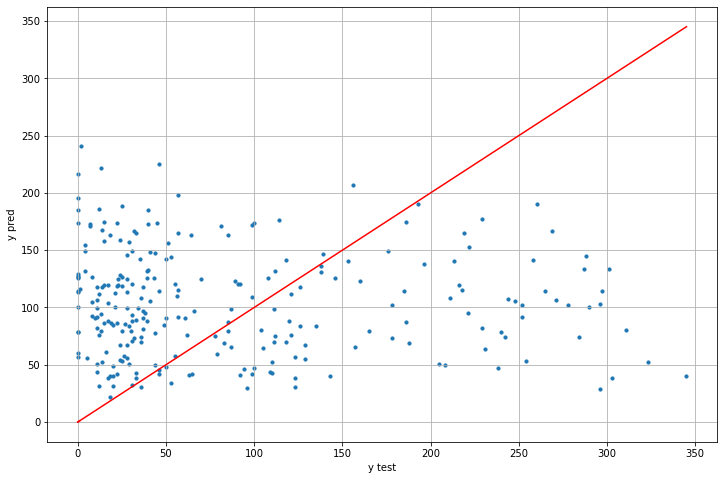

In [246]:
plt.figure(figsize=(12,8))
# plt.scatter(np.sort(y_test),np.sort(ypred),s=1)
plt.scatter(y_test,y_pred,s=10)
plt.xlabel('y test');plt.ylabel('y pred')
plt.plot(np.linspace(0,1.1),np.linspace(0,1.1),'r')
plt.plot(np.linspace(0,max(y_test)),np.linspace(0,max(y_test)),'r')
plt.grid()
plt.show()

Really poor results. However, it can be explained with plots like this one, where the first years air pollution and asthma hospitalization have similar levels, even though the last years they diverge a lot.

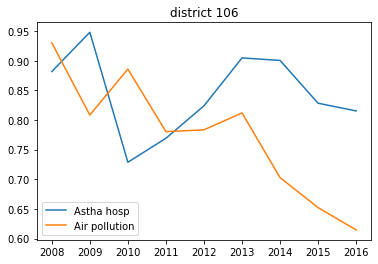

In [249]:
plot_pollution_per_district(106)